# Spatio-temporal tradeoff v2

Replicating the results from Mohler et al in *The Concentration-Dynamics Tradeoff in Crime Hot Spotting*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import pairwise

import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import extract_crime_data, random_crime_data_by_point

In [13]:
FORCE = "West Yorkshire"
filter = {"Crime type": "Anti-social behaviour"}
feature_type: SpatialUnit = "GRID"
feature_area = 40000.0
boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters=filter)

In [14]:
feature_size = {"GRID": np.sqrt(feature_area), "HEX": np.sqrt(feature_area * 2 / (3**1.5))}

crime_data, features = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type])
# remove any outside force boundary
crime_data = crime_data[~crime_data.spatial_unit.isna()]
crime_data

,spatial_unit,BNG_E,BNG_N,LAT,LONG,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,,,,,,
NaN,28724.0,411300.0,447100.0,53.919920,-1.829433,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29225.0,411700.0,447300.0,53.921709,-1.823335,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29976.0,412300.0,447500.0,53.923493,-1.814191,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,72541.0,446500.0,410500.0,53.589027,-1.299002,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [15]:
# features.join(crime_data.groupby("spatial_unit")["Crime type"].count()).explore(
#     "Crime type", tiles="CartoDB positron"
# )  # , missing_kwds={"color": "lightgrey"})
len(features)  # .area.mean()

51567

In [ ]:
def calc_land_area(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    "windows is no of (monthly) columns to aggregate"

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    # average
    # windowed = pd.concat([agg_data.T.rolling(w).sum().T.mean(axis=1).rename(w) for w in windows], axis=1)
    # relative to start
    # windowed = pd.concat([agg_data.iloc[:,:w].sum(axis=1).rename(w) for w in windows], axis=1)
    # relative to end
    windowed = pd.concat([agg_data.iloc[:, -w:].sum(axis=1).rename(w) for w in windows], axis=1)
    land_area = pd.DataFrame(index=windowed.columns, columns=["25% of crime", "50% of crime"])

    for name, series in windowed.items():
        cumulative = series.sort_values().cumsum() / series.sum()
        land_area.loc[name, "25% of crime"] = 100 * len(cumulative[cumulative >= 0.75]) / len(cumulative)
        land_area.loc[name, "50% of crime"] = 100 * len(cumulative[cumulative >= 0.5]) / len(cumulative)

    return land_area


def calc_overlap(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    overlap = pd.DataFrame(index=windows, columns=["25% of crime", "50% of crime"])

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    for w in windows:
        overlaps25 = []
        overlaps50 = []
        for i, j in pairwise(range(0, len(agg_data.columns), w)):
            left = agg_data.iloc[:, i:j].sum(axis=1).sort_values()
            left = left.cumsum() / left.sum()

            left25 = left[left >= 0.75].index
            left50 = left[left >= 0.5].index

            right = agg_data.iloc[:, j : j + w].sum(axis=1).sort_values()
            right = right.cumsum() / right.sum()

            right25 = right[right >= 0.75].index
            right50 = right[right >= 0.5].index

            overlaps25.append(100 * len(np.intersect1d(left25, right25)) / len(np.union1d(left25, right25)))
            overlaps50.append(100 * len(np.intersect1d(left50, right50)) / len(np.union1d(left50, right50)))
        overlap.loc[w, "25% of crime"] = sum(overlaps25) / len(overlaps25)
        overlap.loc[w, "50% of crime"] = sum(overlaps50) / len(overlaps50)

    return overlap


windows = [1, 2, 3, 4, 5, 6, 9, 12, 18]

land_area, overlap = calc_land_area(crime_data, windows), calc_overlap(crime_data, windows)


# the sim... measures are essentially the overlap from above
def calc_spatial_similarity(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    similarity = pd.DataFrame(index=windows, columns=["WSim", "TSim25", "TSim50"])

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    for w in windows:
        wdiffs = []
        sim25 = []
        sim50 = []
        for i, j in pairwise(range(0, len(agg_data.columns), w)):
            left = agg_data.iloc[:, i:j].sum(axis=1)
            right = agg_data.iloc[:, j : j + w].sum(axis=1)

            lrcum = pd.concat(
                [left.sort_values().cumsum() / left.sum(), right.sort_values().cumsum() / right.sum()], axis=1
            ).sort_index()

            x50 = (lrcum >= 0.5).sum(axis=1)
            x25 = (lrcum >= 0.75).sum(axis=1)

            # this maps to: neither: NaN, one: 0, both: 1
            # so mean is N(both) / N(one or both) -> overlap (no need to dropna)
            sim50.append((x50 / x50 + x50 - 2).mean())
            sim25.append((x25 / x25 + x25 - 2).mean())

            # difference, weighted by crime count
            wdiffs.append(np.sqrt((((left - right) * (left + right)) ** 2).mean()))

        similarity.loc[w, "WSim"] = len(wdiffs) / sum(wdiffs)
        similarity.loc[w, "TSim50"] = sum(sim50) / len(sim50)
        similarity.loc[w, "TSim25"] = sum(sim25) / len(sim25)

    return similarity


def calc_predictive_power(crime_data: gpd.GeoDataFrame, windows: list[int]) -> pd.DataFrame:
    predictivity = pd.DataFrame(index=windows, columns=["f1_25", "f1_50", "f1_25_sigma", "f1_50_sigma"])

    agg_data = (
        crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
        .count()
        .unstack(level="Month", fill_value=0)
        .reindex(features.index, fill_value=0)
    )
    assert len(agg_data) == len(features)

    for w in windows:
        f1_50 = []
        f1_25 = []
        for i, j in pairwise(range(0, len(agg_data.columns), w)):
            left = agg_data.iloc[:, i:j].sum(axis=1)
            right = agg_data.iloc[:, j : j + w].sum(axis=1)

            lrcum = pd.concat(
                [left.sort_values().cumsum() / left.sum(), right.sort_values().cumsum() / right.sum()], axis=1
            ).sort_index()

            # this maps to: neither: NaN, one: 0, both: 1,
            # so mean is N(both) / N(one or both) -> overlap (no need to dropna)
            f1_50.append(f1_score(*(c for _, c in (lrcum >= 0.5).items())))
            f1_25.append(f1_score(*(c for _, c in (lrcum >= 0.75).items())))

        predictivity.loc[w, "f1_50"] = np.mean(f1_50)
        predictivity.loc[w, "f1_50_sigma"] = np.std(f1_50)
        predictivity.loc[w, "f1_25"] = np.mean(f1_25)
        predictivity.loc[w, "f1_25_sigma"] = np.std(f1_25)
    return predictivity.fillna(0)


predictivity = calc_predictive_power(crime_data, windows)

/tmp/ipykernel_287207/74573967.py:139: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return predictivity.fillna(0)


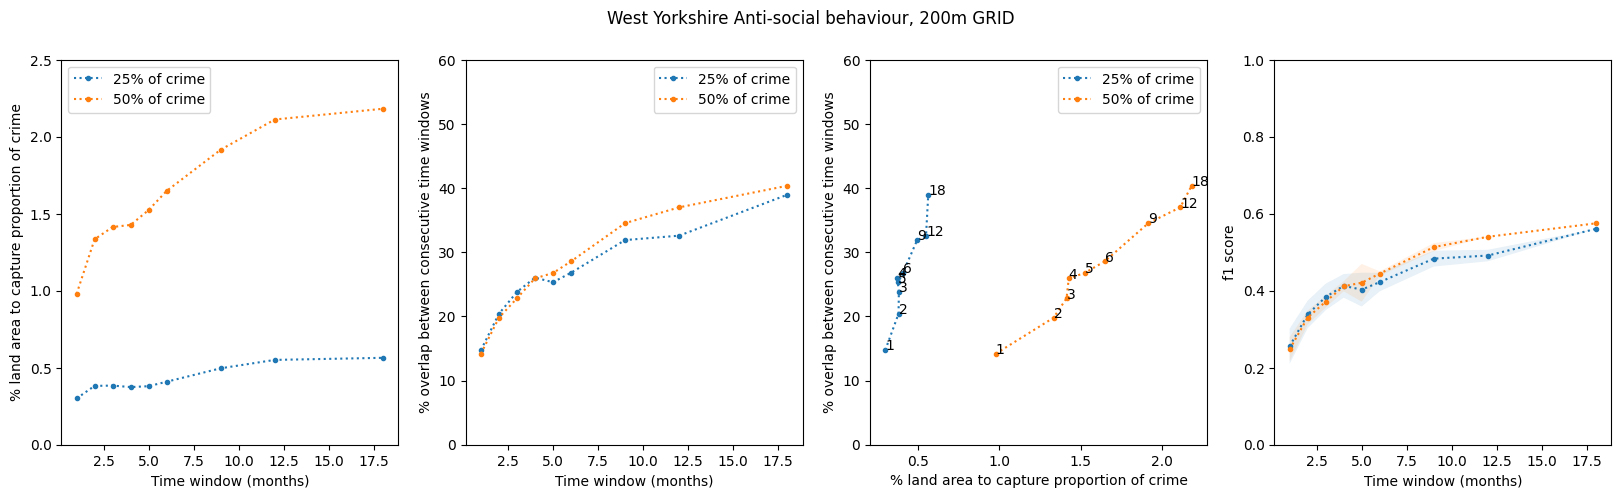

In [17]:
def plot(
    land_area: pd.DataFrame,
    overlap: pd.DataFrame,
    predictivity: pd.DataFrame,
    crime_type: str,
    feature_size: float,
    feature_type: SpatialUnit,
) -> None:
    both = land_area.join(overlap, lsuffix="_land_area").reset_index(names="months")

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"West Yorkshire {crime_type}, {feature_size:.0f}m {feature_type}")

    land_area.plot(
        marker=".",
        ls=":",
        ylabel="% land area to capture proportion of crime",
        xlabel="Time window (months)",
        ax=axs[0],
        ylim=(0, 2.5),
    )

    overlap.plot(
        marker=".",
        ls=":",
        ylabel="% overlap between consecutive time windows",
        xlabel="Time window (months)",
        ax=axs[1],
        ylim=(0, 60),
    )
    axs[2].plot(both["25% of crime_land_area"], both["25% of crime"], label="25% of crime", ls=":", marker=".")
    axs[2].plot(both["50% of crime_land_area"], both["50% of crime"], label="50% of crime", ls=":", marker=".")
    axs[2].set_xlabel("% land area to capture proportion of crime")
    axs[2].set_ylabel("% overlap between consecutive time windows")
    axs[2].set_ylim(0, 60)
    axs[2].legend()

    for x, y, text in zip(both["25% of crime_land_area"], both["25% of crime"], both.months):
        axs[2].text(x, y, text)
    for x, y, text in zip(both["50% of crime_land_area"], both["50% of crime"], both.months):
        axs[2].text(x, y, text)

    axs[3].plot(predictivity.iloc[:, :2], ls=":", marker=".")
    axs[3].set_ylabel("f1 score")
    axs[3].set_ylim(0, 1)
    axs[3].set_xlabel("Time window (months)")
    axs[3].fill_between(
        predictivity.index,
        predictivity.iloc[:, 0] - predictivity.iloc[:, 2],
        predictivity.iloc[:, 0] + predictivity.iloc[:, 2],
        alpha=0.1,
    )
    axs[3].fill_between(
        predictivity.index,
        predictivity.iloc[:, 1] - predictivity.iloc[:, 3],
        predictivity.iloc[:, 1] + predictivity.iloc[:, 3],
        alpha=0.1,
    )


plot(land_area, overlap, predictivity, crime_data["Crime type"].iloc[0], feature_size[feature_type], feature_type)

/tmp/ipykernel_287207/74573967.py:139: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return predictivity.fillna(0)


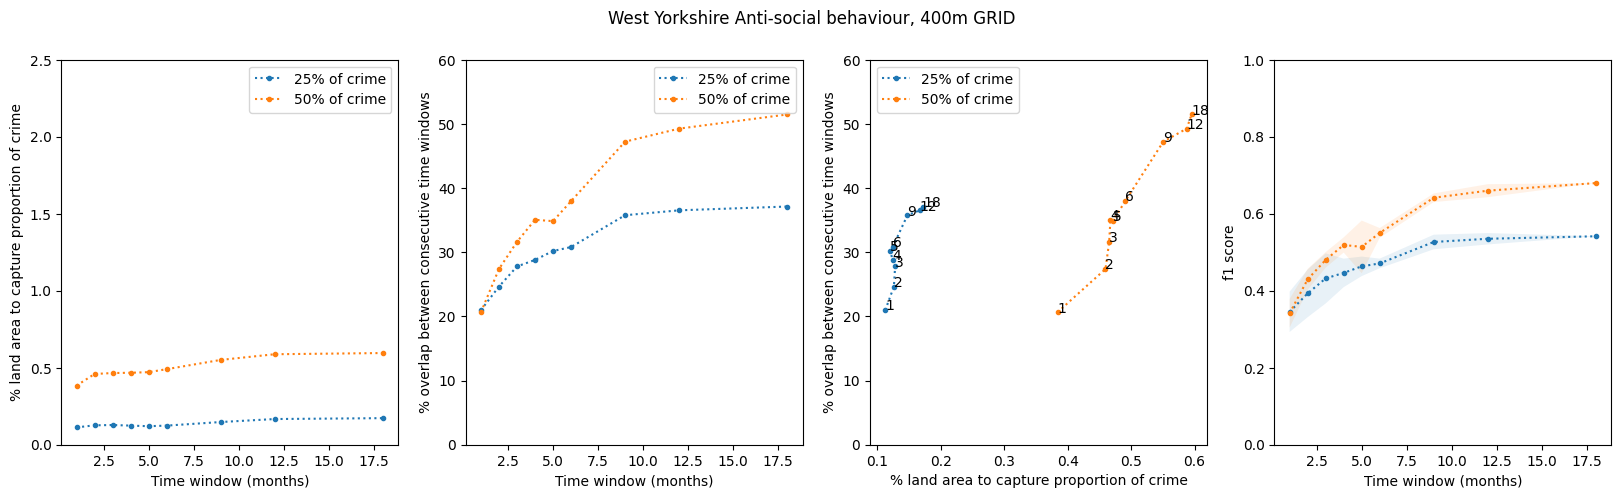

In [18]:
crime_data_400, _ = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type] * 2)
land_area_400, overlap_400 = calc_land_area(crime_data_400, windows), calc_overlap(crime_data_400, windows)
predictivity_400 = calc_predictive_power(crime_data_400, windows)
plot(
    land_area_400,
    overlap_400,
    predictivity_400,
    crime_data["Crime type"].iloc[0],
    feature_size[feature_type] * 2,
    feature_type,
)

/tmp/ipykernel_287207/74573967.py:139: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return predictivity.fillna(0)


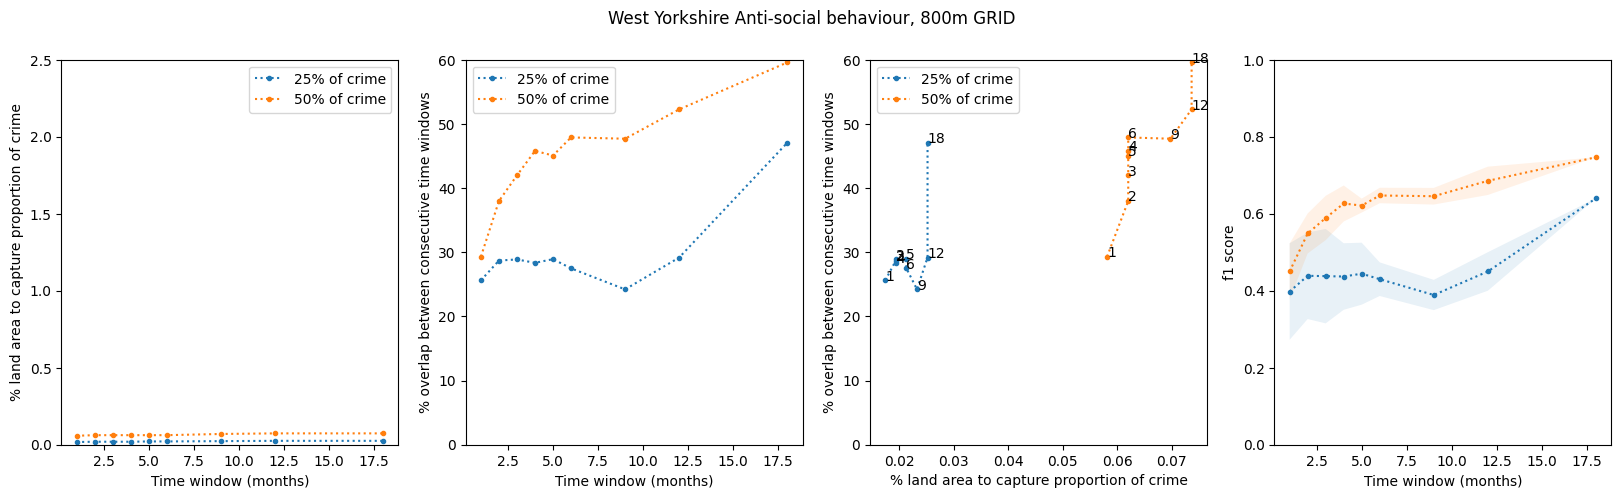

In [19]:
crime_data_800, _ = map_to_spatial_unit(raw_crime_data, boundary, feature_type, size=feature_size[feature_type] * 4)
land_area_800, overlap_800 = calc_land_area(crime_data_800, windows), calc_overlap(crime_data_800, windows)
predictivity_800 = calc_predictive_power(crime_data_800, windows)
plot(
    land_area_800,
    overlap_800,
    predictivity_800,
    crime_data["Crime type"].iloc[0],
    feature_size[feature_type] * 4,
    feature_type,
)

/tmp/ipykernel_287207/74573967.py:139: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return predictivity.fillna(0)


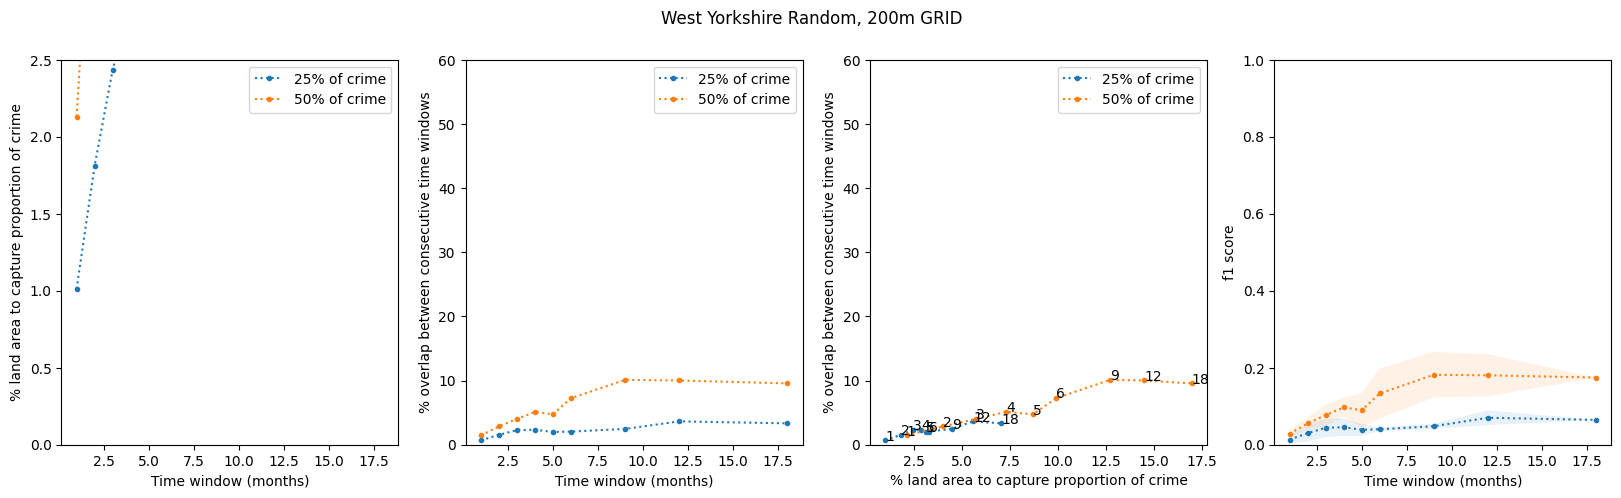

In [20]:
ref_crime_data = random_crime_data_by_point(len(raw_crime_data), boundary, list(raw_crime_data.Month.unique()))
ref_crime_data, _ = map_to_spatial_unit(ref_crime_data, boundary, feature_type, size=feature_size[feature_type])
land_area_ref, overlap_ref = calc_land_area(ref_crime_data, windows), calc_overlap(ref_crime_data, windows)
predictivity_ref = calc_predictive_power(ref_crime_data, windows)
plot(
    land_area_ref,
    overlap_ref,
    predictivity_ref,
    ref_crime_data["Crime type"].iloc[0],
    feature_size[feature_type],
    feature_type,
)